In [1]:
%matplotlib inline

In [2]:
!pip install -q kaggle

In [3]:
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 27.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


In [4]:
!mkdir ~/.kaggle

In [5]:
from google.colab import files

In [6]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"javadnematollahi7371","key":"63e47b7a9e404ff2f7087eadf24562bb"}'}

In [7]:
! cp kaggle.json ~/.kaggle/

In [8]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets list

In [10]:
! kaggle datasets download -d jangedoo/utkface-new

100% 331M/331M [00:15<00:00, 23.1MB/s]
100% 331M/331M [00:15<00:00, 21.8MB/s]


In [11]:
! unzip -qq utkface-new.zip

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from cv2 import imread, resize, cvtColor, COLOR_BGR2RGB
import matplotlib.pyplot as plt
import wandb
from wandb.keras import (
   WandbMetricsLogger,
   WandbModelCheckpoint,
)
run = wandb.init(project="Age_detection")
config = wandb.config
wandb_callbacks = [
   WandbMetricsLogger(log_freq=5),
   WandbModelCheckpoint("models"),
]

In [13]:
width= height= 128

In [14]:
images = []  #X
ages = []    #Y

for image_name in os.listdir("/content/UTKFace"):
    ages.append(int(image_name.split('_')[0]))
    image = imread("UTKFace/"+image_name)
    image = resize(image, (width,height))
    image = cvtColor(image, COLOR_BGR2RGB)
    images.append(image)


In [15]:
images_pd = pd.Series(images, name="Images")
ages_pd = pd.Series(ages, name="Ages")

df = pd.concat([images_pd, ages_pd], axis=1)
df.head()

,Images,Ages
0,"[[[57, 41, 25], [53, 39, 21], [52, 39, 19], [5...",32
1,"[[[34, 19, 14], [36, 21, 16], [38, 23, 17], [4...",24
2,"[[[65, 59, 63], [64, 55, 60], [63, 53, 58], [6...",26
3,"[[[97, 63, 38], [96, 60, 34], [96, 60, 34], [1...",50
4,"[[[135, 127, 108], [135, 127, 108], [136, 128,...",65


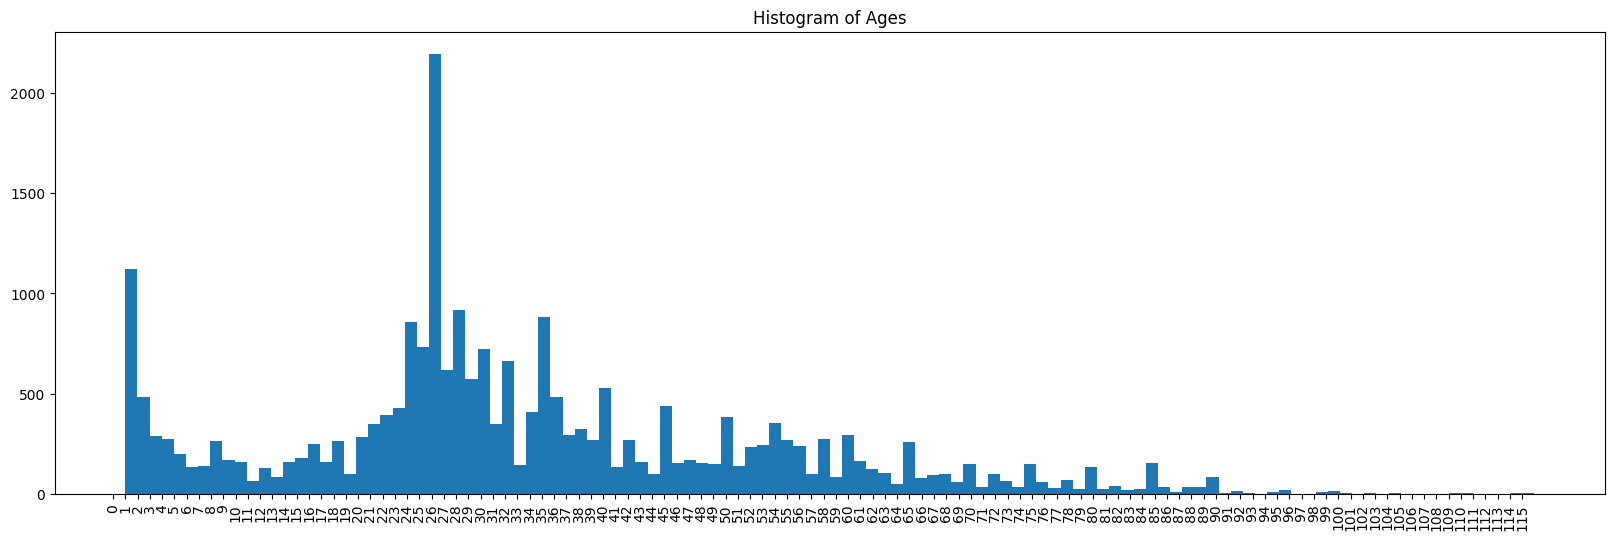

In [16]:
plt.figure(figsize=[20,6])
plt.hist(df["Ages"], bins=max(df['Ages']))
plt.xticks(range(max(df['Ages'])),rotation='vertical')
plt.title("Histogram of Ages")
plt.show()

In [17]:
df = df[df['Ages']<80]

In [18]:
df_26_1 = df[(df["Ages"] == 26) | (df["Ages"] == 1)]
df_without26_1 = df[(df["Ages"] != 26) & (df["Ages"] != 1)]

df_26_1 = df_26_1.sample(frac=0.3)
df = pd.concat([df_26_1, df_without26_1], axis=0)

In [19]:
del df_26_1
del df_without26_1

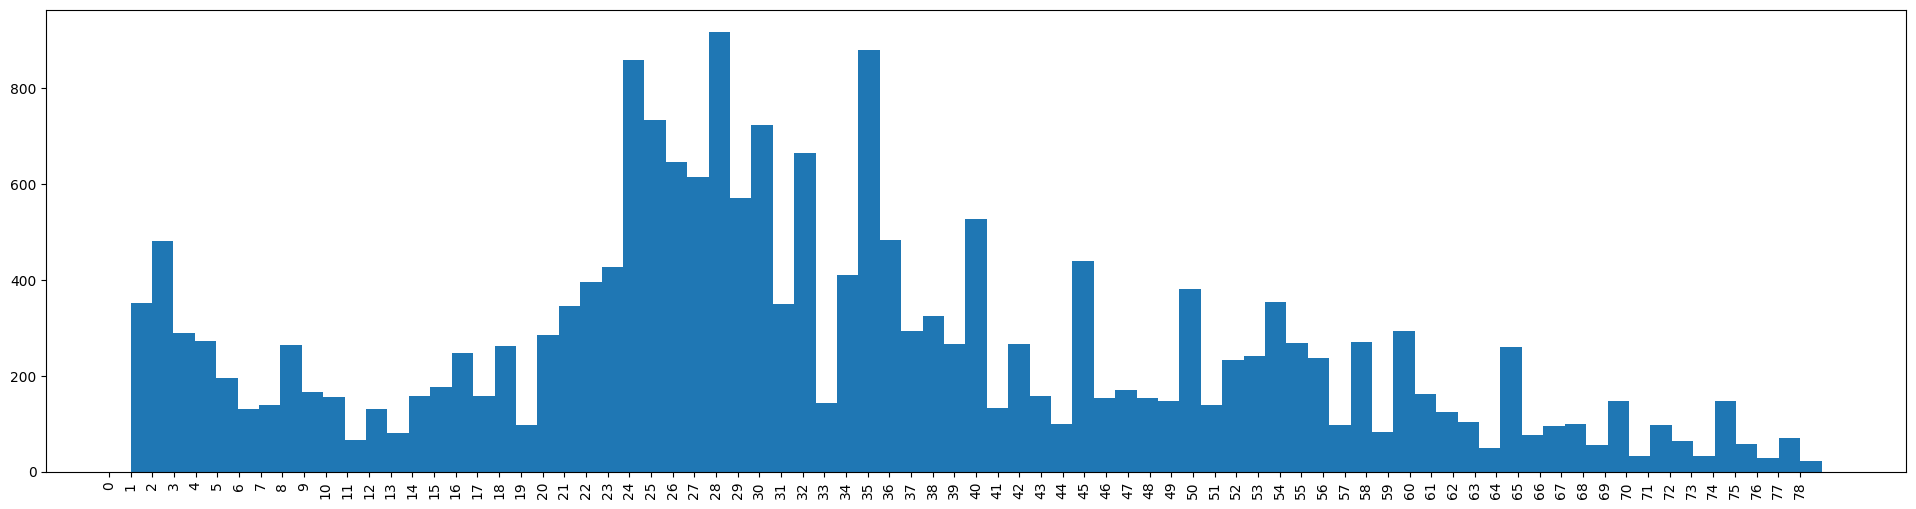

In [20]:
plt.figure(figsize=[24,6])
plt.hist(df["Ages"], bins=max(df['Ages']))
plt.xticks(range(max(df['Ages'])),rotation='vertical')
plt.show()

Concert dataframe pandas to numpy array

In [24]:
X = np.array(df['Images'].values.tolist())
Y = np.array(df['Ages'].values.tolist())

In [25]:
del(df)

In [26]:
X.shape

(20711, 128, 128, 3)

In [27]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.2)

In [28]:
del X
del Y

In [29]:
X_train.shape, X_validation.shape, Y_train.shape, Y_validation.shape

((16568, 128, 128, 3), (4143, 128, 128, 3), (16568,), (4143,))

In [30]:
image_data_generator = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
)

train_data = image_data_generator.flow(
                                       X_train,
                                       Y_train,
                                       batch_size=32,
                                       shuffle=True
                                       )

validation_data = image_data_generator.flow(
                                       X_validation,
                                       Y_validation,
                                       batch_size=16,
                                       shuffle=False
                                       )

In [31]:
del X_train
del Y_train
del X_validation
del Y_validation

# creat model

In [51]:
base_model = tf.keras.applications.MobileNet(
    weights='imagenet',
    include_top=False,
    input_shape=(width,height,3),
    pooling='avg'
)

17225924/17225924 [==============================] - 2s 0us/step


In [52]:
base_model.summary()

Model: "mobilenet_1.00_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 64, 64, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 64, 64, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 64, 64, 32) 

In [53]:
for layer in base_model.layers[0:-10]:
  layer.trainable = False

In [54]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='relu')
])

In [35]:
del images
del ages

In [55]:
model.compile(
    loss= tf.keras.losses.mean_absolute_error,
    optimizer=tf.keras.optimizers.Adam(),
)

checkpoint = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/best_model_age_detection",
                                            save_best_only=True)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

In [56]:
history = model.fit(
          train_data,
          validation_data=validation_data,
          epochs=20,
          callbacks=[stop_early, checkpoint, wandb_callbacks])

Epoch 1/20
517/518 [============================>.] - ETA: 0s - loss: 8.7240

wandb: Adding directory to artifact (./models)... Done. 0.2s


518/518 [==============================] - 44s 75ms/step - loss: 8.7237 - val_loss: 16.9983
Epoch 2/20
516/518 [============================>.] - ETA: 0s - loss: 6.8492

wandb: Adding directory to artifact (./models)... Done. 0.2s


518/518 [==============================] - 36s 70ms/step - loss: 6.8497 - val_loss: 9.3091
Epoch 3/20
518/518 [==============================] - ETA: 0s - loss: 6.4347

wandb: Adding directory to artifact (./models)... Done. 0.1s


518/518 [==============================] - 29s 57ms/step - loss: 6.4347 - val_loss: 16.9059
Epoch 4/20
516/518 [============================>.] - ETA: 0s - loss: 6.2361

wandb: Adding directory to artifact (./models)... Done. 0.2s


518/518 [==============================] - 41s 79ms/step - loss: 6.2339 - val_loss: 6.9253
Epoch 5/20
517/518 [============================>.] - ETA: 0s - loss: 5.9148

wandb: Adding directory to artifact (./models)... Done. 0.1s


518/518 [==============================] - 27s 52ms/step - loss: 5.9122 - val_loss: 6.9721
Epoch 6/20
516/518 [============================>.] - ETA: 0s - loss: 5.7777

wandb: Adding directory to artifact (./models)... Done. 0.1s


518/518 [==============================] - 29s 55ms/step - loss: 5.7814 - val_loss: 11.3929
Epoch 7/20
516/518 [============================>.] - ETA: 0s - loss: 5.5710

wandb: Adding directory to artifact (./models)... Done. 0.2s


518/518 [==============================] - 39s 75ms/step - loss: 5.5738 - val_loss: 6.5846
Epoch 8/20
518/518 [==============================] - ETA: 0s - loss: 5.5105

wandb: Adding directory to artifact (./models)... Done. 1.2s


518/518 [==============================] - 31s 59ms/step - loss: 5.5105 - val_loss: 11.2010
Epoch 9/20
518/518 [==============================] - ETA: 0s - loss: 5.3430

wandb: Adding directory to artifact (./models)... Done. 0.1s


518/518 [==============================] - 28s 55ms/step - loss: 5.3430 - val_loss: 6.5879
Epoch 10/20
518/518 [==============================] - ETA: 0s - loss: 5.1858

wandb: Adding directory to artifact (./models)... Done. 3.6s


518/518 [==============================] - 30s 58ms/step - loss: 5.1858 - val_loss: 6.7130
Epoch 11/20
516/518 [============================>.] - ETA: 0s - loss: 5.0638

wandb: Adding directory to artifact (./models)... Done. 0.3s


518/518 [==============================] - 29s 55ms/step - loss: 5.0634 - val_loss: 7.6625
Epoch 12/20
516/518 [============================>.] - ETA: 0s - loss: 4.9806

wandb: Adding directory to artifact (./models)... Done. 0.3s


518/518 [==============================] - 30s 58ms/step - loss: 4.9813 - val_loss: 8.2829
Epoch 13/20
518/518 [==============================] - ETA: 0s - loss: 4.8223

wandb: Adding directory to artifact (./models)... Done. 0.2s


518/518 [==============================] - 25s 48ms/step - loss: 4.8223 - val_loss: 9.4496
Epoch 14/20
518/518 [==============================] - ETA: 0s - loss: 4.7387

wandb: Adding directory to artifact (./models)... Done. 4.2s


518/518 [==============================] - 31s 59ms/step - loss: 4.7387 - val_loss: 7.2300
Epoch 15/20
518/518 [==============================] - ETA: 0s - loss: 4.7120

wandb: Adding directory to artifact (./models)... Done. 0.3s


518/518 [==============================] - 41s 78ms/step - loss: 4.7120 - val_loss: 6.4590
Epoch 16/20
518/518 [==============================] - ETA: 0s - loss: 4.5403

wandb: Adding directory to artifact (./models)... Done. 0.5s


518/518 [==============================] - 26s 50ms/step - loss: 4.5403 - val_loss: 7.9589
Epoch 17/20
516/518 [============================>.] - ETA: 0s - loss: 4.5066

wandb: Adding directory to artifact (./models)... Done. 3.3s


518/518 [==============================] - 43s 84ms/step - loss: 4.5063 - val_loss: 6.0879
Epoch 18/20
518/518 [==============================] - ETA: 0s - loss: 4.3725

wandb: Adding directory to artifact (./models)... Done. 0.9s


518/518 [==============================] - 28s 55ms/step - loss: 4.3725 - val_loss: 8.5702
Epoch 19/20
516/518 [============================>.] - ETA: 0s - loss: 4.3026

wandb: Adding directory to artifact (./models)... Done. 3.7s


518/518 [==============================] - 32s 61ms/step - loss: 4.3023 - val_loss: 8.4616
Epoch 20/20
517/518 [============================>.] - ETA: 0s - loss: 4.2944

wandb: Adding directory to artifact (./models)... Done. 4.2s


518/518 [==============================] - 41s 79ms/step - loss: 4.2915 - val_loss: 7.2401


In [57]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/best_model_age_detection')

loaded_model.evaluate(validation_data)

259/259 [==============================] - 4s 12ms/step - loss: 6.0586


6.058568477630615

In [59]:
drive.mount('/gdrive', force_remount=True)
loaded_model.save('/gdrive/MyDrive/dataset/Age_prediction.h5')

Mounted at /gdrive


In [60]:
loaded_model = tf.keras.models.load_model('/gdrive/MyDrive/dataset/Age_prediction.h5')

loaded_model.evaluate(validation_data)

259/259 [==============================] - 5s 17ms/step - loss: 6.0935


6.0935163497924805

In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1/1 [==============================] - 1s 515ms/step
[[32.37311]]


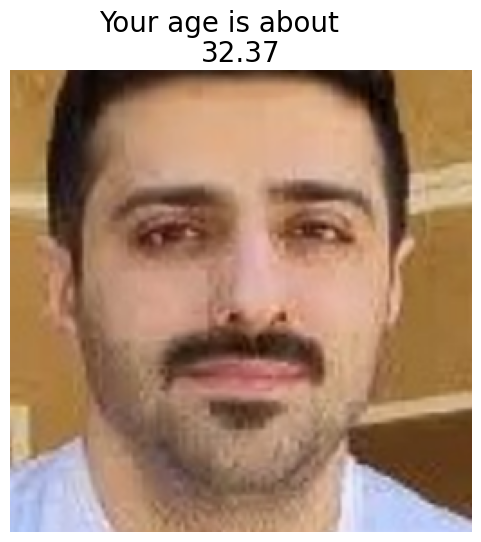

In [4]:
import cv2
import dlib
from Align_face_own import *

# loaded_model = tf.keras.models.load_model('/gdrive/MyDrive/dataset/Age_prediction.h5')
loaded_model = tf.keras.models.load_model('weights/Age_prediction.h5')

def predict(image_path):
  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor("weights/shape_predictor_68_face_landmarks.dat")
  fa = FaceAligner(predictor, desiredFaceWidth=256)
  # load the input image, resize it, and convert it to grayscale
  image = cv2.imread(image_path)
  image = imutils.resize(image, width=800)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # show the original input image and detect faces in the grayscale
  # image
  rects = detector(gray, 2)
  fig = plt.figure(figsize=(18,6))
  # loop over the face detections
  for i,rect in enumerate(rects):
    # extract the ROI of the *original* face, then align the face
    # using facial landmarks
    # (x, y, w, h) = rect_to_bb(rect)
    # faceOrig = imutils.resize(image[y:y + h, x:x + w], width=256)
    faceAligned = fa.align(image, gray, rect)

    image_RGB = cv2.cvtColor(faceAligned, cv2.COLOR_BGR2RGB)
    image_edit = cv2.resize(image_RGB, (128, 128))
    image_data=image_edit.reshape(1,128,128,3)
    image_data = image_data / 255.0
    age_pred = loaded_model.predict(image_data)
    print(age_pred)
    # return preds,image
    # age,image = predict('input/00.jpg')
    # age_pred=round(age_pred[0][0], 2)
    # plt.title("Your age is about\n",fontsize = 30)
    fig.add_subplot(1, len(rects), i+1)
    plt.imshow(image_RGB)
    plt.axis("off")
    plt.title("{:.2f}".format(age_pred[0][0]),fontsize = 20)

  plt.suptitle("Your age is about\n",fontsize = 20)
  plt.show()


predict('input/javad.jpg')